In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR
from torchvision import transforms

In [ ]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-bjm8bi1v
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-bjm8bi1v
     |████████████████████████████████| 634kB 7.7MB/s 
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=29695 sha256=84a2c75b8c117bfe70593db4d557a904265417ae5dd8dd138644852af4fb05fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ci59xu7u/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=79dd4bc6bfd460275a2680ba17c02dc3257535064f22a236f114542786f36cbf
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built eva5utils imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18, Model11
from eva5utils.transforms import model9_resnet_test_transforms, model11_davidnet_train_transforms
from eva5utils.train import train_loop
from eva5utils.train import train_onecyclelr
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam, LRRangeFinder
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [ ]:
# Constants, put in config
epochs = 24
cuda_batch_size=512
cpu_batch_size = 4
num_workers = 4
 
 
model = Model11()
model1 = Model11()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model11_davidnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

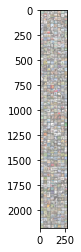

In [ ]:
plot_samples(trainloader)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: Maximum Accuracy
Suggested LR: 1.00E-01


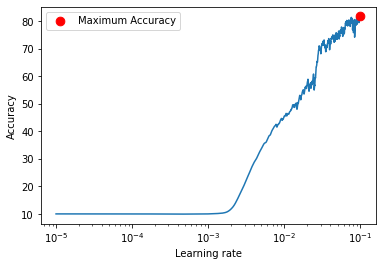

0.1


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
lr_range_finder = LRRangeFinder(model, optimizer, criterion, device=DEVICE)
lr_range_finder.range_test(trainloader, testloader, end_lr=.1, num_iter=2343, step_mode="linear")
_, lr = lr_range_finder.plot() # to inspect the accuracy-learning rate graph
lr_range_finder.reset() # to reset the model and optimizer to their initial state
print(lr)